# Определение возраста покупателей

Описание проекта


Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Нужно построить модель, которая по фотографии определит приблизительный возраст человека.

План работы:

- Загрузить данные;
- Провести исследовательский анализ;
- Построить модель, для определения приблизительного возраста человека;
- Оценить качество полученной модели.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.shape

(7591, 2)

Построим график распределения возраста по выборке.

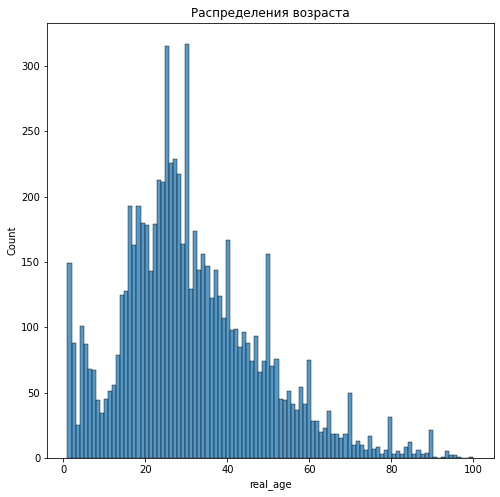

In [5]:
plt.figure(figsize=(8, 8))
sns.histplot(df['real_age'], bins=100);
plt.title('Распределения возраста');

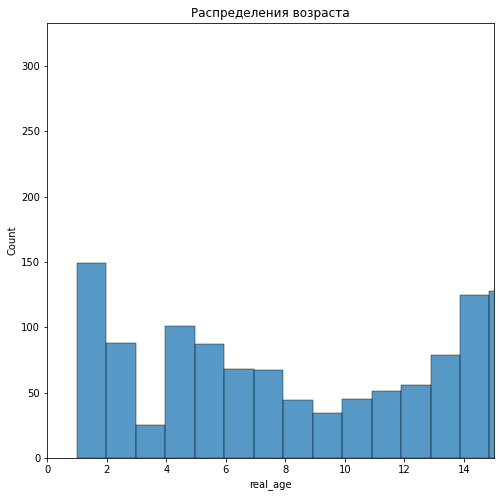

In [6]:
plt.figure(figsize=(8, 8))
sns.histplot(df['real_age'], bins=100);
plt.xlim(0, 15);
plt.title('Распределения возраста');

Мы видим небольшое количество фотографий в диапазоне от 6 до 13 лет.

In [7]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


50% всех фотографий попадают в диапазон от 20 до 41 года.

Напечатаем 12 фотографий.

In [19]:
RANDOM_STATE=12345

train_datagen = ImageDataGenerator(rescale=1/255.) # загрузим данные
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 7591 validated image filenames.


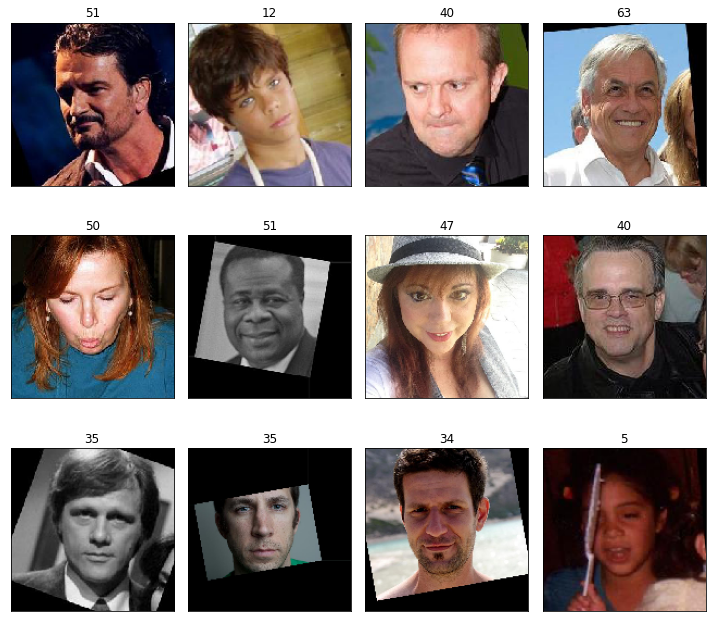

In [22]:
features, target = next(train_datagen_flow)

# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i]);
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

В данных 7591 фотография. Широкий разброс и малое количество фотографий для некоторых возрастов могут усложнить способность сети определять возраст. Различия в качестве фотографий, цвете и наличиe рамок также могут сказаться на качестве.

## Обучение модели

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

RANDOM_STATE = 12345

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=path + 'final_files/',
    target_size=(256, 256),
    batch_size=32,
    x_col='file_name',
    y_col='real_age',
    class_mode='other',
    subset='training',
    seed=RANDOM_STATE)
    
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=path + 'final_files/',
    target_size=(256, 256),
    batch_size=32,
    x_col='file_name',
    y_col='real_age',
    class_mode='other',
    subset='validation',
    seed=RANDOM_STATE)
    
    return test_datagen_flow


def create_model(input_shape):
    optimizer=Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
      
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

**Вывод модели:**

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
178/178 - 55s - loss: 227.1598 - mae: 10.8604 - val_loss: 918.0884 - val_mae: 25.4803
Epoch 2/20
178/178 - 43s - loss: 77.0194 - mae: 6.6311 - val_loss: 521.8719 - val_mae: 17.5779
Epoch 3/20
178/178 - 44s - loss: 47.4676 - mae: 5.2873 - val_loss: 274.6407 - val_mae: 12.0992
Epoch 4/20
178/178 - 45s - loss: 35.5929 - mae: 4.5724 - val_loss: 112.4993 - val_mae: 8.2071
Epoch 5/20
178/178 - 47s - loss: 28.0502 - mae: 4.0617 - val_loss: 79.5150 - val_mae: 6.7745
Epoch 6/20
178/178 - 46s - loss: 21.8407 - mae: 3.5757 - val_loss: 75.1169 - val_mae: 6.4100
Epoch 7/20
178/178 - 47s - loss: 18.2376 - mae: 3.2520 - val_loss: 75.4285 - val_mae: 6.8209
Epoch 8/20
178/178 - 47s - loss: 14.5409 - mae: 2.9163 - val_loss: 60.3350 - val_mae: 5.8418
Epoch 9/20
178/178 - 46s - loss: 13.7269 - mae: 2.8239 - val_loss: 62.1669 - val_mae: 6.0291
Epoch 10/20
178/178 - 47s - loss: 12.3792 - mae: 2.6717 - val_loss: 64.4798 - val_mae: 6.1380
Epoch 11/20
178/178 - 46s - loss: 9.7741 - mae: 2.3889 - val_loss: 74.4958 - val_mae: 6.4808
Epoch 12/20
178/178 - 46s - loss: 9.1382 - mae: 2.2764 - val_loss: 61.9214 - val_mae: 5.7987
Epoch 13/20
178/178 - 47s - loss: 8.9020 - mae: 2.2605 - val_loss: 59.7820 - val_mae: 5.7208
Epoch 14/20
178/178 - 46s - loss: 8.1636 - mae: 2.1438 - val_loss: 72.3251 - val_mae: 6.3858
Epoch 15/20
178/178 - 47s - loss: 7.6295 - mae: 2.0916 - val_loss: 60.8104 - val_mae: 5.9559
Epoch 16/20
178/178 - 47s - loss: 7.0772 - mae: 2.0170 - val_loss: 64.0849 - val_mae: 6.0472
Epoch 17/20
178/178 - 47s - loss: 7.7619 - mae: 2.0882 - val_loss: 61.2475 - val_mae: 5.7881
Epoch 18/20
178/178 - 47s - loss: 7.3194 - mae: 2.0456 - val_loss: 57.3035 - val_mae: 5.7392
Epoch 19/20
178/178 - 47s - loss: 7.7152 - mae: 2.0553 - val_loss: 66.0236 - val_mae: 5.9533
Epoch 20/20
178/178 - 46s - loss: 6.8901 - mae: 2.0081 - val_loss: 60.0024 - val_mae: 5.8485
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 60.0024 - mae: 5.8485
Test MAE: 5.8485


```

**Вывод**

На данном этапе мы обучили модель на архитектуре ResNet50 и получили MAE удовлетворяющую условию.

## Анализ обученной модели

В данном проекте мы:
- провели исследовательский анализ и выявили на каких данных будем обучать модель;
- разработали модель на архитектуре ResNet50 и получили MAE = 5,85.

С таким показателем качества можно успешно оценивать привычки покупателей разных возрастных категорий и стать хорошим помощником при выявлении недобросовестных продавцов алкоголя.

Мы видим, что качество модели улучшается с каждой эпохой и их увеличение поможет нам достичь требуемых показателей.